In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(stringr))
library(viridis)
library(scales)
library(RColorBrewer)
library(parallel)
library(purrr)
library(ggplot2)
library(igraph)
library(ggraph)
library(colormap)
library(rstatix)
library(corrplot)
library(GGally)
options(warn=-1)

mid_rescaler <- function(mid = 0) {
  function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
    scales::rescale_mid(x, to, from, mid)
  }
}
cor.mtest <- function(mat, conf.level = 0.95) {
  mat <- as.matrix(mat)
  n <- ncol(mat)
  p.mat <- matrix(NA, n, n)
  diag(p.mat) <- 0
  for (i in 1:(n - 1)) {
    for (j in (i + 1):n) {
      tmp <- cor.test(mat[, i], mat[, j], 
                      method='spearman',
                      conf.level = conf.level)
      p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
    }
  }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  p.mat
}

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal



Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard



Attaching package: ‘igraph’


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tibble’:

    as_data_frame


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


corrplot 0.85 loaded

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
T_cell_data<-read.csv("01_Get_Metrics/BRI_Tcell_data_forcorrelation.csv")
T_cell_data<-T_cell_data[,-1]
B_cell_data<-read.csv("01_Get_Metrics/BRI_Bcell_data_forcorrelation.csv",check.names = FALSE)
B_cell_data<-B_cell_data[,-1]


In [3]:
new_colnames <- names(T_cell_data)
new_colnames[2:length(new_colnames)] <- str_c("T_", new_colnames[2:length(new_colnames)])
names(T_cell_data) <- new_colnames

new_colnames <- names(B_cell_data)
new_colnames[2:length(new_colnames)] <- str_c("B_", new_colnames[2:length(new_colnames)])
names(B_cell_data) <- new_colnames

In [4]:
combined_df<-left_join(T_cell_data,B_cell_data)

Joining with `by = join_by(subject.subjectGuid)`


In [5]:

combined_df<-combined_df[ , -which(names(combined_df) %in% 
                                   c('B_CoreMemoryB_HALLMARK_MYC_TARGETS_V2','B_CoreMemoryB_Freq_Fold_Changes',
                                     'B_CoreMemoryB_HALLMARK_ALLOGRAFT_REJECTION',
                                     'B_CoreMemoryB_HALLMARK_MTORC1_SIGNALING',
                                     #'B_MSD_phuket_fold_change',
                                     'T_flow_Tfh_PD1pos_mean_diff',
                                     'T_flow_Tfh_PD1neg_mean_diff'))]

In [6]:
meta_data<-read.csv("/home/jupyter/BRI_Figures_Final_V2/Figure5/01_Frequency_Comparison/selected_samples_with_acutal_flu_year.csv")

In [7]:
meta_data$Ages<-meta_data$subject.birthYear


In [8]:
combined_df<-left_join(combined_df,unique(meta_data[c('subject.subjectGuid','Ages')]))

Joining with `by = join_by(subject.subjectGuid)`


In [9]:
combined_df<-combined_df %>% filter(T_NMF_Th2<0.1)

In [10]:
replacements <- c("T_NMF_Th2" = "CM CD4 T-Th2 Score",
                  "T_NMF_Tfh" = "CM CD4 T-Tfh Score",
                  
                  "Mock" = "Mock",
                  
                  "Ages" = "Biological Ages",
                  "T_Down_composite_score_sum_scaled_mean" = "CM CD4 T-Age Composite Metric (Down)",
                  "T_Up_composite_score_sum_scaled_mean" = "CM CD4 T-Age Composite Metric (Up)",
                  
                  "T_InteractionScore_CD40LG_CD40" = "CM CD4 T/Core memory B-CD40LG_CD40 Interaction Score",
                  "T_InteractionScore_PTPRC_CD22" = "CM CD4 T/Core memory B-PTPRC_CD22 Interaction Score",
                  "T_Mean_Expression_CD40LG" = "CM CD4 T-CD40LG Mean Expression",
                  "T_Mean_Expression_CXCR5" = "CM CD4 T-CXCR5 Mean Expression",
                  
                  "B_CoreMemoryB_HALLMARK_TNFA_SIGNALING_VIA_NFKB" = "Core memory B-TNFA SIGNALING VIA NFKB Pathway Score",
                  "B_CoreMemoryB_HALLMARK_PI3K_AKT_MTOR_SIGNALING" = "Core memory B-PI3K AKT MTOR SIGNALING Pathway Score",
                  "B_CoreMemoryB_HALLMARK_MYC_TARGETS_V1" = "Core memory B-MYC TARGETS V1 Pathway Score",
                  "B_HAI_phuket_day7" = "HAI Assay-Day 7 Inhibition",
                  "B_HAI_fold_change"= "HAI Assay-Day 7/0 Delta Change",
                  "B_Mean_Expression_CD19" = "CD27 effector B-CD19 Mean Expression",
                  "B_Plasma_Freq_Fold_Changes" = "Plasma Cell-Day7/Day0 Frequency(CLR) Changes"
             
                 )

In [11]:
colnames(combined_df) <- ifelse(colnames(combined_df) %in% names(replacements), replacements[colnames(combined_df)], colnames(combined_df))

In [12]:
colnames(combined_df)

[1] "subject.subjectGuid"                                 
 [2] "CM CD4 T-Th2 Score"                                  
 [3] "CM CD4 T-Tfh Score"                                  
 [4] "CM CD4 T-Age Composite Metric (Down)"                
 [5] "CM CD4 T-Age Composite Metric (Up)"                  
 [6] "CM CD4 T/Core memory B-CD40LG_CD40 Interaction Score"
 [7] "CM CD4 T/Core memory B-PTPRC_CD22 Interaction Score" 
 [8] "CM CD4 T-CD40LG Mean Expression"                     
 [9] "CM CD4 T-CXCR5 Mean Expression"                      
[10] "Core memory B-TNFA SIGNALING VIA NFKB Pathway Score" 
[11] "Core memory B-PI3K AKT MTOR SIGNALING Pathway Score" 
[12] "Core memory B-MYC TARGETS V1 Pathway Score"          
[13] "B_MSD_phuket_fold_change"                            
[14] "HAI Assay-Day 7/0 Delta Change"                      
[15] "Plasma Cell-Day7/Day0 Frequency(CLR) Changes"        
[16] "B_Mean_Expression_IGHG3"                             
[17] "CD27 effector B-CD19 Mean Expression"                
[18] "Biological Ages"

In [13]:
df_long<-combined_df %>%
  dplyr::select(
    `CM CD4 T-Th2 Score`,
    `CM CD4 T-Age Composite Metric (Up)`,
    `CM CD4 T/Core memory B-CD40LG_CD40 Interaction Score`,
    `Core memory B-TNFA SIGNALING VIA NFKB Pathway Score`,
    `HAI Assay-Day 7/0 Delta Change`
  ) %>%
  tidyr::pivot_longer(
      col=2:5,
    names_to = "Variable",
    values_to = "Value"
  )
head(df_long)

CM CD4 T-Th2 Score,Variable,Value
<dbl>,<chr>,<dbl>
0.02061264,CM CD4 T-Age Composite Metric (Up),9.808068
0.02061264,CM CD4 T/Core memory B-CD40LG_CD40 Interaction Score,0.581000
0.02061264,Core memory B-TNFA SIGNALING VIA NFKB Pathway Score,3.440999
0.02061264,HAI Assay-Day 7/0 Delta Change,NA
0.01594233,CM CD4 T-Age Composite Metric (Up),-54.998541
0.01594233,CM CD4 T/Core memory B-CD40LG_CD40 Interaction Score,0.628000


In [14]:
correlation_tests

ERROR: Error in eval(expr, envir, enclos): object 'correlation_tests' not found


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


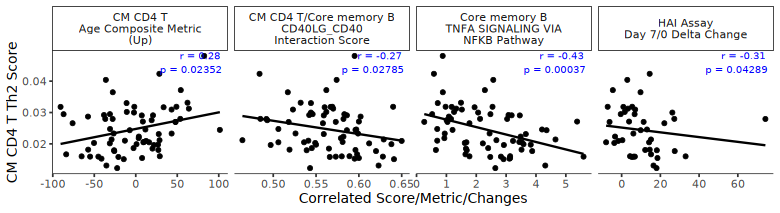

In [23]:
options(repr.plot.width = 165/25.4, repr.plot.height =45/25.4)

correlation_tests <- df_long %>% #filter(Variable=='Core_Memory_B_TNFA_SIGNALING_VIA_NFKB_Pathway') %>%
  dplyr::group_by(Variable) %>%
  dplyr::summarise(
    correlation = cor( `CM CD4 T-Th2 Score`,Value, method = 'spearman', use = "pairwise.complete.obs"),
    p_value = cor.test(Value, `CM CD4 T-Th2 Score`, method = 'spearman')$p.value
  )

p <- ggplot(data = df_long ,#%>% filter(Variable=='Core_Memory_B_TNFA_SIGNALING_VIA_NFKB_Pathway'),
            aes(x = Value, y = `CM CD4 T-Th2 Score`)) +
  geom_point(size = 1, stroke = 0.25) +
  geom_smooth(method = 'lm', color = "black", se = FALSE, linewidth = 0.5) +
  facet_wrap(~ Variable, scales = "free_x", ncol=4, labeller = labeller(Variable = c(
    "CM CD4 T-Age Composite Metric (Up)" = "CM CD4 T\nAge Composite Metric\n(Up)",
      "CM CD4 T/Core memory B-CD40LG_CD40 Interaction Score" = "CM CD4 T/Core memory B\nCD40LG_CD40\nInteraction Score",
      "Core memory B-TNFA SIGNALING VIA NFKB Pathway Score" = "Core memory B\nTNFA SIGNALING VIA\nNFKB Pathway",
      "HAI Assay-Day 7/0 Delta Change" = "HAI Assay\nDay 7/0 Delta Change"
  ))) +
  theme_classic(base_size = 8) +
  ylab('CM CD4 T Th2 Score') +
  xlab('Correlated Score/Metric/Changes') +
  geom_text(
    data = correlation_tests,
    aes(
      x = Inf, y = Inf,
      label = paste("r =", round(correlation, 2), "\np =", format.pval(p_value, digits = 2, eps = 0.000001)),
      hjust = 1.1, vjust = 1.1
    ),
    inherit.aes = FALSE,
    size = 2,
    color = "blue")+theme(
          panel.border = element_blank())+
  theme(
    strip.background = element_rect(colour = "black", size = 0.15),
          axis.line = element_line(size = 0.15)  
  )
print(p)
ggsave("FigureB.pdf",p, width=165/25.4,height = 45/25.4)